[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/ot_gan_ensae/blob/master/sinkhorn_gan.ipynb)


# OT GAN 

Kasmi Gabriel, Hugo Thimonier

ENSAE 3A - 2019-2020

This notebook summarizes our attempts to replicate the results of the paper <i> Learning Generative Models with Sinkhorn Divergences </i> of Genevay, Peyré and Cuturi (2017).

Following the MNIST experiment, we built our multilayer perceptron and then tried to learn the digits of the MNIST dataset by minimizing the sinkhorn loss. 

This notebook is self contained, the only requirement is to have Cuda working, which is the case on Google's colab environment. 

The notebook is organized as follows:  

After doing the necessary imports (section 0), we define our model (section 1), test it on a "dummy" example to see if it is working properly (section 2). We then turn to the OT-GAN approach by building our own loss function and try to learn the target distribution by differentiating the Sinkhorn loss (section 3)


The interested reader can find further details on our approach in the report attached to this notebook.

For more details about the actual implementation, one can refer to the notebooks <tt> autodiff_ot_gan </tt> and <tt> autodiff_ot_gan_checkpoint </tt> that are located in the ```draft``` folder. In particular, the notebook <tt> autodiff_ot_gan_checkpoint </tt> contains all our approaches and trials. In this notebook we only summarize the main results that we've obtained. 

## 0. Imports and helpers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot
!pip install POT
import ot

     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=3a8a3f9eb02174484efa50ff7755c6b57d005513e1db00c0380b1cbaef00f3c2
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 430kB 4.6MB/s 


In [0]:
cuda = torch.cuda.is_available()

if not cuda :
  print('Warning, cuda not detected')

In [0]:
# Helper to plot the images

def imshow(img):
    """
    takes a tensor as input and returns an image
    """
    if cuda:
      np_img = img.detach().cpu().numpy()
    else:
      np_img = img.detach().numpy()
    plt.imshow(np.reshape(np_img,(28,28)), cmap='gray_r' )
    plt.show()

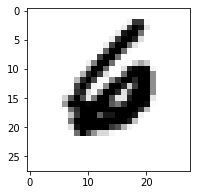

In [40]:
# import the dataset

transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1024

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images_np = images.numpy()


# get one image from the batch
img = np.squeeze(images_np[np.random.randint(len(images))])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray_r')
plt.show()

## 1. Definition of the model

In [0]:
class MultilayerPerceptron(nn.Module):
    """
    A MLP with 1 hidden layer
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
    Constructor of the MLP.
    Arguments:
    - input_size : number of neurons in the first layer 
    (aka latent space dimension)
    - hidden_size : number of neurons in the hidden layer
    - outout_size : number of neurons in the last layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        # self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        hidden = self.hidden(x)
        relu = self.relu(hidden)
        output = self.output(relu)
        # output = self.sigmoid(output)
        # output = self.relu(output)
        return output
    

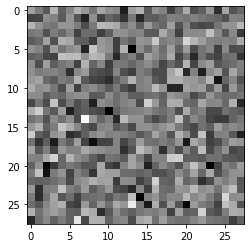

In [0]:
# quick check that everything is working as expected

null_model = MultilayerPerceptron(2, 500, 28*28)
z = torch.rand(2)
imshow(null_model(z))

## 2. Sanity checks on the model 

### 2.1. Tests on a batch of images

The goal of this test is to see whether the model we've defined is working. We train it against a simple $\ell_2$ loss. After traning, the model should always output an "average" image. We can see that it is indeed the case. 

In [0]:
# test if the network is training as expected on a dummy example
# should generate an "average" image

if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(test.parameters(), lr = 0.0002) # same optimizer as in the paper

z_size = 2
test.train()
epochs = 25 # not necessary to put many epochs
samples_evolution = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, real_images) # this loss will be replaced by the sinkhorn loss
   
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
#    if epoch%10==0:    
#        # add an image to the list to see the improvements
#        print('Generating an image after %s epochs' %epoch)
#        x = torch.rand(2, requires_grad=True).cuda()
#        samples_evolution.append(test.forward(x))

Epoch 0: train loss: 0.26603
Epoch 1: train loss: 0.26554
Epoch 2: train loss: 0.26602
Epoch 3: train loss: 0.26772
Epoch 4: train loss: 0.27012
Epoch 5: train loss: 0.26920
Epoch 6: train loss: 0.26775
Epoch 7: train loss: 0.26781
Epoch 8: train loss: 0.26775
Epoch 9: train loss: 0.26772
Epoch 10: train loss: 0.26771
Epoch 11: train loss: 0.26769
Epoch 12: train loss: 0.26768
Epoch 13: train loss: 0.26768
Epoch 14: train loss: 0.26768
Epoch 15: train loss: 0.26768
Epoch 16: train loss: 0.26768
Epoch 17: train loss: 0.26766
Epoch 18: train loss: 0.26767
Epoch 19: train loss: 0.26767
Epoch 20: train loss: 0.26767
Epoch 21: train loss: 0.26767
Epoch 22: train loss: 0.26767
Epoch 23: train loss: 0.26767
Epoch 24: train loss: 0.26767


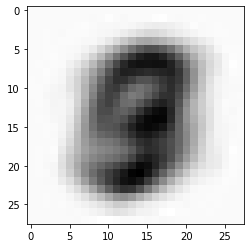

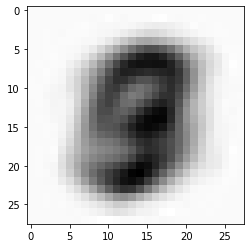

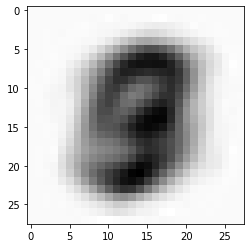

In [0]:
# plot the results
z = torch.rand(3,2).cuda()
samples = test(z)
for img in samples:
  imshow(img)

### 2.2. Tests on a single image

This test is even simpler : we train the model against one image. At the end, no matter the input, the model should return the same image. As it can be seen, it is indeed the case. 

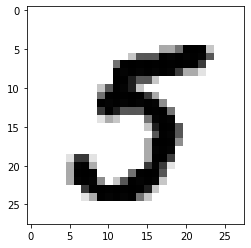

In [0]:
# Definition of the target image
target = real_images[0]
imshow(target)

In [0]:
# test if the network is training as expected on a dummy example
# even simpler test, overfit to one image.


if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(test.parameters(), lr = 0.02) # same optimizer as in the paper

z_size = 2
test.train()
epochs = 10 # not necessary to put many epochs
# samples_evolution = []
#losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, target.cuda()) # this loss will be replaced by the sinkhorn loss
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    #losses.append(loss.item())
    #if epoch%10==0:    
        # add an image to the list to see the improvements
        #print('Generating an image after %s epochs' %epoch)
        #x = torch.rand(2, requires_grad=False).cuda()
        #samples_evolution.append(test(x))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([200, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train loss: 0.00002
Epoch 1: train loss: 0.00001
Epoch 2: train loss: 0.00000
Epoch 3: train loss: 0.00000
Epoch 4: train loss: 0.00000
Epoch 5: train loss: 0.00000
Epoch 6: train loss: 0.00000
Epoch 7: train loss: 0.00000
Epoch 8: train loss: 0.00000
Epoch 9: train loss: 0.00000


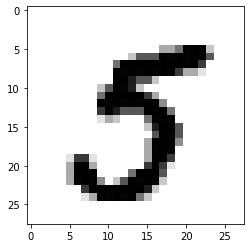

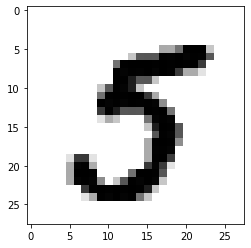

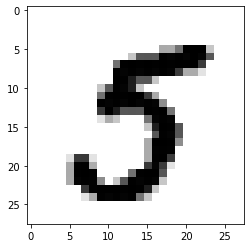

In [0]:
# generate some random vectors and some images 
# copies of the original image are indeed generated.

z = torch.rand(3,2).cuda()
target_copies = test.forward(z)

for img in target_copies:
  imshow(img)


The model is indeed working and training as expected. We can turn to the implementation of the OT-GAN

## 3. OT-GAN

We follow the guidelines of the paper. The only change is that we consider a cosine similarity matrix (as in <i> Improving GANs Using Optimal Transport </i>) because it turns out that using this cost matrix, the computation of the Sinkhorn loss is more stable (see the notebooks contained in the drafts for more information). 

We define three bricks : the cost matrix, the sinkhorn iterates to approximate the transport plan and the computation of the sinkhorn loss which is given by 
$$
\bar{W}(\mu,\nu) = 2 W(\mu,\nu) - W(\mu,\mu) - W(\nu,\nu)
$$
Where $W$ is the transport cost $W = \langle P_\varepsilon, M_{\mu,\nu}\rangle$, $M_{\mu,\nu}$ the cost matrix and $P_\varepsilon$ the transport plan, approximated by the Sinkhorn algorithm with regularization strength $\varepsilon$.

### 3.1. Definition of the loss

In [0]:
class CosineCostMatrix(nn.Module):
  def __init__(self):
    super(CosineCostMatrix,self).__init__()

  def forward(self, x,y):
    """
    takes x and y tensors as inputs and returns the cosine similarity
    """
    return 1 - torch.mm(x.cuda(),y.t().cuda()) / (torch.norm(x).cuda() * torch.norm(y).cuda())

class SinkhornIterates(nn.Module):
  def __init__(self):
    super(SinkhornIterates,self).__init__()

  def forward(self, C, epsilon = 0.1, max_iters = 100):
    """
    Computes the approximate transport plan and the 
    associated cost based on distance matrix C 
    """

    # dimensions of the data (should be the same in our case)
    n, m = C.size()

    # Sinkhorn iterates
    a = torch.ones(m).cuda()
    b = torch.ones(n).cuda()

    #actual loop 
    v = torch.ones(n).cuda()

    K = torch.exp(-C/epsilon)
    for _ in range(max_iters):
      u = a / torch.mv(K,v).cuda()
      v = b / torch.mv(K.t(), u).cuda()

    M = torch.matmul(torch.matmul(torch.diag(u),K),torch.diag(v)).cuda()
    return torch.sum(M*C)

class SinkhornLoss(nn.Module):
  def __init__(self):
    super(SinkhornLoss,self).__init__()

  def forward(self, x,y, epsilon = 0.1, max_iters = 100):
    cost_matrix = CosineCostMatrix()
    sinkhorn_iterates = SinkhornIterates()

    # computation of the distance matrices
    C_xy = cost_matrix(x, y)
    C_xx = cost_matrix(x, x)
    C_yy = cost_matrix(y, y)

    # computation of the losses 

    W_xy = sinkhorn_iterates(C_xy, epsilon = epsilon, max_iters = max_iters)
    W_xx = sinkhorn_iterates(C_xx, epsilon = epsilon, max_iters = max_iters)
    W_yy = sinkhorn_iterates(C_yy, epsilon = epsilon, max_iters = max_iters)

    return 2 * W_xy - W_xx - W_yy   

In [0]:
# We just run a quick sanity check to see if this is working as expected 
# Generate two random tensors 
z1 = torch.rand(16, 2)
z2 = torch.rand(16, 2)
y_rand1 = null_model(z1)
y_rand2 = null_model(z2)

# compute the sinkhorn loss, should be non-negative and 0 if x = y
sk_loss = SinkhornLoss()
print(sk_loss(y_rand1, y_rand2),sk_loss(y_rand1, y_rand1) )

tensor(0.0040, device='cuda:0', grad_fn=<SubBackward0>) tensor(0., device='cuda:0', grad_fn=<SubBackward0>)


### 3.2. Traning and results

In [41]:
# train the model with the custom loss

new_model = MultilayerPerceptron(2, 500, 784).cuda()

# training with custom loss
optimizer = torch.optim.Adam(new_model.parameters(), lr = 0.0002) # after several trials, seting a very low lr seems to improve learning
criterion = SinkhornLoss()

z_size = 2
new_model.train()
epochs = 50
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28)
        real_images.cuda()

        optimizer.zero_grad()
        
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = new_model(z)
            
        # Compute Loss 
        loss = criterion(y_pred, real_images)

        loss.backward()
        optimizer.step()

    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements (if any)
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=False).cuda()
        samples_evolution_sk.append(new_model.forward(x))

Epoch 0: train loss: 0.02533
Generating an image after 0 epochs
Epoch 1: train loss: 0.02167
Epoch 2: train loss: 0.01501
Epoch 3: train loss: 0.00903
Epoch 4: train loss: 0.00922
Epoch 5: train loss: 0.00800
Epoch 6: train loss: 0.00714
Epoch 7: train loss: 0.00726
Epoch 8: train loss: 0.00787
Epoch 9: train loss: 0.00830
Epoch 10: train loss: 0.00732
Generating an image after 10 epochs
Epoch 11: train loss: 0.00885
Epoch 12: train loss: 0.00763
Epoch 13: train loss: 0.00769
Epoch 14: train loss: 0.00751
Epoch 15: train loss: 0.00787
Epoch 16: train loss: 0.00848
Epoch 17: train loss: 0.00739
Epoch 18: train loss: 0.00787
Epoch 19: train loss: 0.00934
Epoch 20: train loss: 0.00757
Generating an image after 20 epochs
Epoch 21: train loss: 0.00739
Epoch 22: train loss: 0.00745
Epoch 23: train loss: 0.00818
Epoch 24: train loss: 0.00739
Epoch 25: train loss: 0.00769
Epoch 26: train loss: 0.00812
Epoch 27: train loss: 0.00885
Epoch 28: train loss: 0.00848
Epoch 29: train loss: 0.00806
Epo

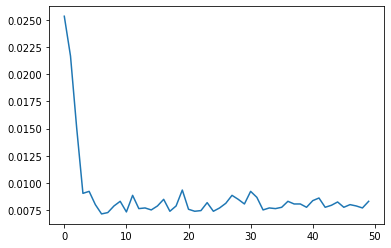

In [42]:
# Plot the loss over the epochs 
plt.plot(losses)
# plt.savefig('losses_summary_notebook.png')


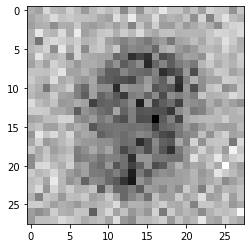

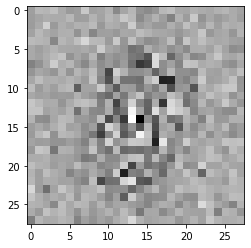

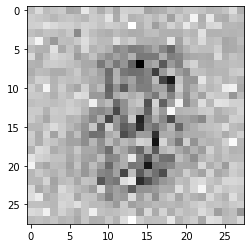

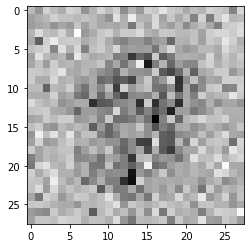

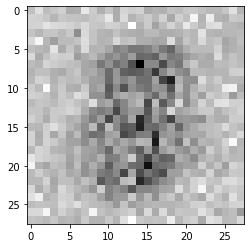

In [43]:
# Plot the evolution while training
for img in samples_evolution_sk:
  imshow(img)


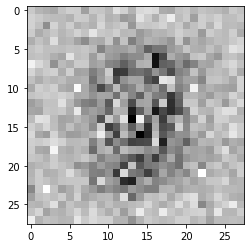

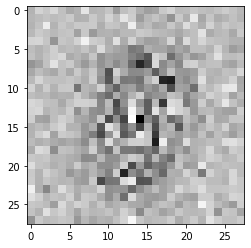

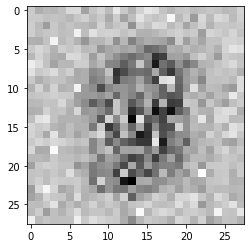

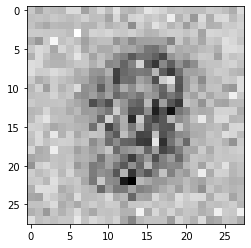

In [44]:
# Generate some samples with the trained model

x = torch.rand(4,2).cuda()
generated_images = new_model.forward(x)
for img in generated_images:
  imshow(img)
# not really a mnist digit, but not noise either
# also seems to give different numbers

We can see an improvement during the training, the model is not generating noise anymore, but despite our efforts the model is far from generating authentic MNIST images. 

We've tried several combination of batch sizes, learning rates but none of these gave significantly better results than what is returned here. We noticed that the loss function reached a minimum, preventing the model from further improvements but for this value of the loss function (in the present case around 0.025) the model doesn't generate genuine samples. 

A possible explanation for this may be that the range of the cosine loss is too narrow. As numerical approximations during the computation of the loss increase, even for a small learning rate the model is unable to significantly improve its performance. 

To overcome this difficulty, we tried to implement the squared norm distance matrix but the latter returned <tt> nan </tt>, which is why we sticked to the cosine similarity.

We've tried with several batch sizes, ranging from 128 to 2048 as well as several learning rates. The overall behavior is the same : the model will quickly converge and then remain "stuck" at a given level. The learning rate affects the speed of convergence as well as its "stability" while the larger the batch size, the smaller the loss.